In [1]:
# Use the same features defined for other models 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("archive/Stocks/aapl.us.txt")
df = df.iloc[:,:-1]

df['MA_Open_5'] = df['Open'].rolling(5).mean()
df['MA_Close_5'] = df['Close'].rolling(5).mean()
df['MA_Volume_5'] = df['Volume'].rolling(5).mean()

delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

tp = (df['High'] + df['Low'] + df['Close']) / 3
ma = tp.rolling(20).mean()
dev = (tp - ma).abs().rolling(20).mean()
cci = (tp - ma) / (0.015 * dev)
df['CCI_20'] = cci

df['EMA_Close_10'] = df['Close'].ewm(span=10, adjust=False).mean()

sma = df['Close'].rolling(20).mean()
std = df['Close'].rolling(20).std()
df['BB_upper_20'] = sma + 2 * std
df['BB_lower_20'] = sma - 2 * std

df[df.columns.difference(['Date'])] = df[df.columns.difference(['Date'])].apply(lambda x: x.fillna(x.mean()))

In [2]:
# Will implement Support Vector Machine through sklearn library
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import datetime as dt
from sklearn.preprocessing import StandardScaler

df['Date'] = pd.to_datetime(df['Date'])


cutoff_date = pd.to_datetime('2014-01-01')
train = df[df['Date'] < cutoff_date]
test = df[df['Date'] >= cutoff_date]

# Split the training and test sets into features and target
X_train = train.drop(['Date', 'Close'], axis=1)
y_train = train['Close']
X_test = test.drop(['Date', 'Close'], axis=1)
y_test = test['Close']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Basic Model
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
# Train the model 
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
display(y_pred)

array([-2.85150305e+00,  3.35222172e-01,  2.09990534e+00,  7.95891842e-01,
        7.15776230e-01,  1.42309372e+00,  2.47560450e+00,  3.12267101e+00,
        1.08634534e+00,  1.50989074e-01, -1.28124107e+00,  2.08716890e+00,
        2.75464459e-01,  3.74770311e-02,  6.85773461e-02,  1.53850181e+00,
        3.73089501e+00,  2.45592712e+01,  1.87743432e+01,  2.04460687e+01,
        1.89385669e+01,  1.70893951e+01,  1.17569064e+01,  9.65314918e+00,
        6.31182137e+00,  4.85762166e+00,  3.69759838e+00,  1.63193216e+00,
        1.43978103e+00,  5.07541948e-01, -3.46271090e-01, -7.72357057e-01,
       -1.11383445e-01,  3.63326510e-01,  2.18400501e-01,  8.83438211e-01,
        4.92390961e-01,  1.36734840e+00,  1.44187942e+00,  1.82229709e+00,
        8.40325573e-01,  5.11081805e-01,  6.00305493e-02,  5.19000174e-01,
        5.76247920e-01,  6.80401120e-01, -4.53015653e-01, -1.00394785e+00,
       -7.35106210e-01,  1.11350525e+00,  7.91178247e-01,  3.57446132e-01,
       -9.72822449e-01, -

MSE: 9719.701292155532
MAE: 98.03862604584678
RMSE: 98.58854544091587


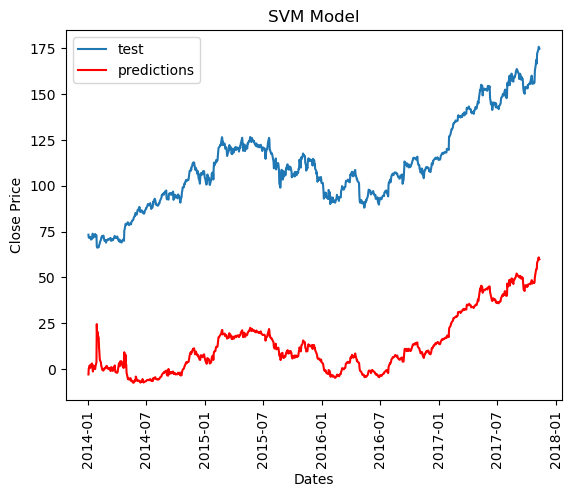

In [3]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot


# evaluate forecasts
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
# plot forecasts against actual outcomes
dates = df[df['Date'] >= cutoff_date]['Date']
pyplot.plot(dates, y_test, label='test')
pyplot.plot(dates, y_pred, color='red', label = 'predictions')
pyplot.legend(loc="upper left")
pyplot.setp(pyplot.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
pyplot.xlabel("Dates")
pyplot.ylabel("Close Price")
pyplot.title("SVM Model")

pyplot.show()

In [4]:
# Grid search to find better parameters
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01,0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


grid_predictions = grid.predict(X_test)
  
mse = mean_squared_error(y_test, grid_predictions)
mae = mean_absolute_error(grid_predictions, y_test)
rmse = np.sqrt(mse)
print(f'Best RMSE: {rmse}')

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END .....C=0.001, gamma=1, kernel=rbf;, score=-3.515 total time=   2.2s
[CV 2/5] END .....C=0.001, gamma=1, kernel=rbf;, score=-0.490 total time=   2.2s
[CV 3/5] END .....C=0.001, gamma=1, kernel=rbf;, score=-0.049 total time=   2.2s
[CV 4/5] END .....C=0.001, gamma=1, kernel=rbf;, score=-0.638 total time=   2.1s
[CV 5/5] END .....C=0.001, gamma=1, kernel=rbf;, score=-3.636 total time=   1.9s
[CV 1/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-3.255 total time=   2.1s
[CV 2/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-0.602 total time=   2.1s
[CV 3/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-0.169 total time=   2.1s
[CV 4/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-0.507 total time=   1.9s
[CV 5/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-3.608 total time=   1.9s
[CV 1/5] END ..C=0.001, gamma=0.01, kernel=rbf;, score=-3.161 total time=   2.2s
[CV 2/5] END ..C=0.001, gamma=0.01, kernel=rbf;

[CV 2/5] END ........C=10, gamma=1, kernel=rbf;, score=-4.297 total time=   4.1s
[CV 3/5] END .......C=10, gamma=1, kernel=rbf;, score=-10.807 total time=   4.1s
[CV 4/5] END .........C=10, gamma=1, kernel=rbf;, score=0.551 total time=   3.5s
[CV 5/5] END ........C=10, gamma=1, kernel=rbf;, score=-2.601 total time=   1.2s
[CV 1/5] END ......C=10, gamma=0.1, kernel=rbf;, score=-5.001 total time=   1.3s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.934 total time=   1.3s
[CV 3/5] END ......C=10, gamma=0.1, kernel=rbf;, score=-0.972 total time=   1.3s
[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.992 total time=   1.0s
[CV 5/5] END ......C=10, gamma=0.1, kernel=rbf;, score=-2.240 total time=   0.4s
[CV 1/5] END .....C=10, gamma=0.01, kernel=rbf;, score=-1.738 total time=   0.8s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.989 total time=   0.9s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.627 total time=   0.8s
[CV 4/5] END ......C=10, gam

MSE: 10139.731965077839
MAE: 100.57285273624224
RMSE: 100.69623610184166


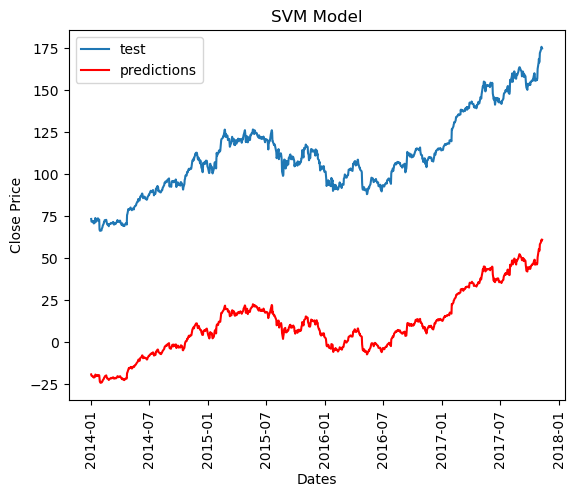

In [6]:
# evaluate forecasts
mae = mean_absolute_error(y_test, grid_predictions)
mse = mean_squared_error(y_test, grid_predictions)
rmse = sqrt(mse)

# plot forecasts against actual outcomes
dates = df[df['Date'] >= cutoff_date]['Date']
pyplot.plot(dates, y_test, label='test')
pyplot.plot(dates, grid_predictions, color='red', label = 'predictions')
pyplot.legend(loc="upper left")
pyplot.setp(pyplot.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
pyplot.xlabel("Dates")
pyplot.ylabel("Close Price")
pyplot.title("SVM Model")

pyplot.show()
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')